In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function
import os
import sys
import argparse
import gc

# standard numerical library imports
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt



import tensorflow as tf
from tensorflow import keras

import keras.backend as K
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.initializers import Constant
from tensorflow.keras.backend import concatenate

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical



In [2]:
# parse cli arguments
'''
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="How many training iterations shoud be run?")
    # LHE arg
    parser.add_argument("-i", "--iter", help="Int. Number of repeated training runs with randomized samples", default = 5)
    args = parser.parse_args()
    NUM = args.num
else:
'''
NUM = 5


In [2]:
memory=8192*0.9
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory)])
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
# print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")



2024-08-12 23:41:33.516137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 23:41:33.522040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 23:41:33.522283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 23:41:33.523147: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# define training iter function and helpful setup_nn function

def setup_nn(Phi_sizes = (100,100,128), F_sizes = (100,100,100), input_dim=1, patience = 15, save_label = 'DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal', out_dir = './saved_models'):

    dctr = PFN(input_dim = input_dim,
               Phi_sizes = Phi_sizes, 
               F_sizes   = F_sizes,
               summary   = False)

    os.makedirs(os.path.dirname(f'{out_dir}/{save_label}.h5'), exist_ok=True) # create output dir, if it doesn't exist
    
    checkpoint = keras.callbacks.ModelCheckpoint(f'{out_dir}/{save_label}.h5',
                                                    monitor='val_loss',
                                                    verbose=2,
                                                    save_best_only=True,
                                                    mode='min')
    
    CSVLogger = keras.callbacks.CSVLogger(f'{out_dir}/{save_label}_loss.csv', append=False)
    
    EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0,
                                                  patience=patience,
                                                  verbose=1,
                                                  restore_best_weights=True)
    
    callbacks = [checkpoint, CSVLogger, EarlyStopping]

    return dctr, callbacks




def train_single_iteration(X0, X1, iteration, num_events = int(4e6), batch_size = 1000, save_label = 'DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal', out_dir = './saved_models'):
    K.clear_session()
    gc.collect() # collect garbage to free memory
    
    # take random num_evts from each dataset
    rand0 = np.random.choice(len(X0), num_events) # num_evts random indices
    rand1 = np.random.choice(len(X1), num_events)

    local_X0 = X0[rand0]
    local_X1 = X1[rand1]

    # create classifier array Y
    Y0 = np.array([0. for i in range(local_X0.shape[0])])
    Y1 = np.array([1. for i in range(local_X1.shape[0])])

    Y = np.concatenate((Y0, Y1))
    Y = to_categorical(Y, num_classes=2)

    # create training array
    X = []
    X = np.concatenate((local_X0, local_X1))
    
    X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.25, shuffle=True)

    del rand0, rand1, local_X0, local_X1, X, Y # delete the tmp variables to free memory
    gc.collect() # collect garbage to free memory

    with tf.device('/cpu:0'):
        X_train = tf.convert_to_tensor(X_train)
        X_val   = tf.convert_to_tensor(X_val)
        Y_train = tf.convert_to_tensor(Y_train)
        Y_val   = tf.convert_to_tensor(Y_val)
    
    # ready to start training
    dctr, callbacks = setup_nn(save_label = f'{save_label}_iter_{iteration:02d}', out_dir = out_dir)

    print('Starting training')
    history = dctr.fit(X_train, Y_train,
                       epochs = 1000,
                       batch_size = batch_size,
                       validation_data = (X_val, Y_val),
                       verbose = 1,
                       callbacks = callbacks)
    
    dctr.save(f'{out_dir}/{save_label}_iter_{iteration:02d}.h5')
    
    plt.figure(figsize=(6,5))
    plt.plot(history.history['loss'],     label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val loss')
    plt.legend(loc=0)
    plt.ylabel('loss')
    plt.xlabel('Epochs')
    plt.savefig(f'{out_dir}/{save_label}_iter_{iteration:02d}_history.pdf')

    del history, dctr, callbacks, X_train, X_val, Y_train, Y_val # delete vars to free memory
    K.clear_session()
    gc.collect() # collect garbage to free memory


In [4]:
data_dir = '../../Data'

# NAF
# data_dir = '/nfs/dust/cms/user/puschman/pythia8307/examples/output'


### aggrgate data from 15 runs with different seeds

12 runs are for the training, where each training will receive 4M random samples from the ~12M total for each class.

X0: Rb 1.056

X1: Rb 0.855



In [5]:
X0 = []

for i in range(1, 13):
    dataset = np.load(f'{data_dir}/B-Fragmentation_Rb_1.056/bootstrapping_Xb_multC_multNeutra_listBtop_listBextra-Rb_1.056_1M_seed{i}_CP5.npz')
    print(dataset.files)
    X0.extend(dataset['a'])

X0 = np.array(X0)
print(X0.shape)



['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
(23911152,)


In [6]:
X1 = []

for i in range(1, 13):
    dataset = np.load(f'{data_dir}/B-Fragmentation_Rb_0.855/bootstrapping_Xb_multC_multNeutra_listBtop_listBextra-Rb_0.855_1M_seed{i}_CP5.npz')
    print(dataset.files)
    X1.extend(dataset['a'])

X1 = np.array(X1)
print(X1.shape)


['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
(23912424,)


In [7]:
print(X0.shape)
print(X1.shape)


(23911152,)
(23912424,)


In [8]:
X0_pari = []
X0_dispari = []
X1_pari = []
X1_dispari = []


for i, _ in enumerate(X0):
    if i % 2 == 0:
        X0_pari.append(X0[i])
    else:
        X0_dispari.append(X0[i])


for i, _ in enumerate(X1):
    if i % 2 == 0:
        X1_pari.append(X1[i])
    else:
        X1_dispari.append(X1[i])


In [9]:
print(len(X0_pari))
print(len(X1_pari))

11955576
11956212


In [10]:
print(len(X0_dispari))
print(len(X1_dispari))

11955576
11956212


In [11]:
X0_tot = []
for i, _ in enumerate(X0_pari):
    X0_tot.append([[X0_pari[i]], [X0_dispari[i]]])
    

In [12]:
X0_tot = np.array(X0_tot)
print(X0_tot.shape)


(11955576, 2, 1)


In [13]:
print(X0_tot)

[[[0.4727821 ]
  [0.77345092]]

 [[0.81807189]
  [0.68890812]]

 [[0.31941123]
  [0.89386035]]

 ...

 [[0.6885071 ]
  [0.68362032]]

 [[0.42146701]
  [0.77048908]]

 [[0.37598829]
  [0.36507024]]]


In [14]:
X1_tot = []
for i, _ in enumerate(X1_pari):
    X1_tot.append([[X1_pari[i]], [X1_dispari[i]]])
    

In [15]:
X1_tot = np.array(X1_tot)
print(X1_tot.shape)


(11956212, 2, 1)


In [16]:
print(X1_tot)

[[[0.4727821 ]
  [0.77345092]]

 [[0.81807189]
  [0.7358395 ]]

 [[0.32661311]
  [0.91397603]]

 ...

 [[0.86739354]
  [0.81468214]]

 [[0.81390241]
  [0.85790137]]

 [[0.92550745]
  [0.99964699]]]


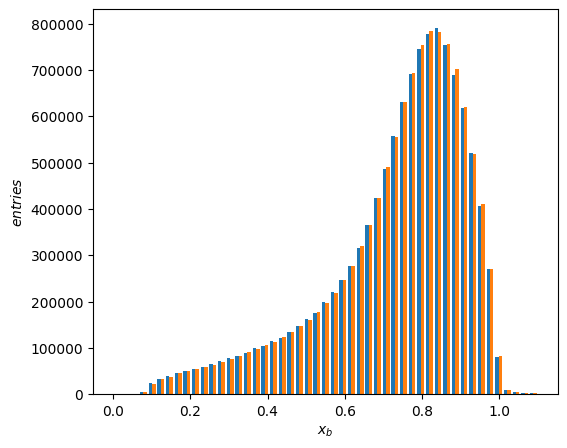

In [19]:
# xb X0
plt.figure(figsize=(6,5))
bins = np.linspace(0,1.1,50)
hist0 = plt.hist(X0_tot[:,:,0], bins = bins)


plt.xlabel(r'$x_b$')
plt.ylabel('$entries$')
#plt.yscale('log')
plt.show()

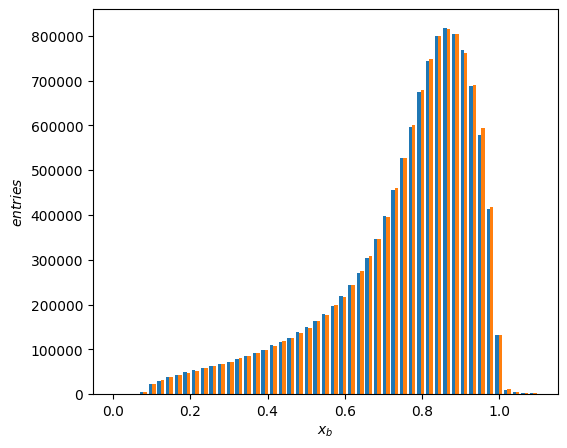

In [20]:
# xb X1
plt.figure(figsize=(6,5))
bins = np.linspace(0,1.1,50)
hist0 = plt.hist(X1_tot[:,:,0], bins = bins)


plt.xlabel(r'$x_b$')
plt.ylabel('$entries$')
#plt.yscale('log')
plt.show()

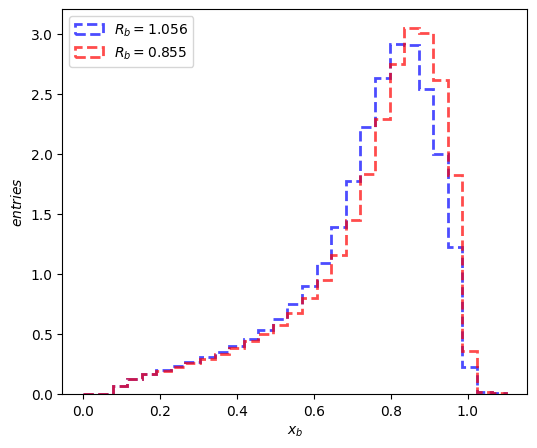

In [21]:
# xb
plt.figure(figsize=(6,5))
bins = np.linspace(0,1.1,30)
plot_style_0 = {'histtype':'step', 'color':'blue', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'histtype':'step', 'color':'red', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_2 = {'histtype':'step', 'color':'green', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_3 = {'histtype':'step', 'color':'orange', 'linewidth':2, 'linestyle':'--', 'density':True}
hist0 = plt.hist(X0_tot[:,0,0], bins = bins, alpha=0.7, label = r'$R_b = 1.056$', **plot_style_0)
hist1 = plt.hist(X1_tot[:,0,0], bins = bins, alpha=0.7, label = r'$R_b = 0.855$', **plot_style_1)

plt.xlabel(r'$x_b$')
plt.ylabel('$entries$')
#plt.yscale('log')
plt.legend(loc='upper left')
plt.show()

Starting training
Epoch 1/1000
5981/6000 [============================>.] - ETA: 0s - loss: 0.6900 - acc: 0.5329
Epoch 1: val_loss improved from inf to 0.68579, saving model to ./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_iter_01.h5
6000/6000 [==============================] - 16s 2ms/step - loss: 0.6900 - acc: 0.5329 - val_loss: 0.6858 - val_acc: 0.5502
Epoch 2/1000
6000/6000 [==============================] - ETA: 0s - loss: 0.6860 - acc: 0.5499
Epoch 2: val_loss did not improve from 0.68579
6000/6000 [==============================] - 14s 2ms/step - loss: 0.6860 - acc: 0.5499 - val_loss: 0.6867 - val_acc: 0.5480
Epoch 3/1000
5993/6000 [============================>.] - ETA: 0s - loss: 0.6857 - acc: 0.5505
Epoch 3: val_loss improved from 0.68579 to 0.68548, saving model to ./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_iter_01.h5
6000/6000 [==============================] - 15s 3ms/step - loss: 0.6857 - acc: 0.5505 - val_loss: 0.6855 - val_acc: 0.5509
Epoch 4/1000
6000/60

KeyboardInterrupt: 

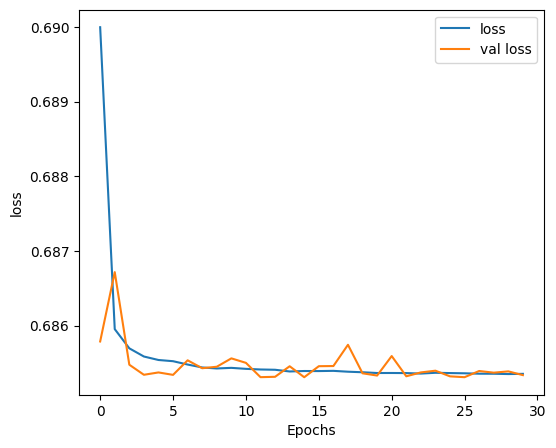

In [27]:
# NUM iterations with 4M random samples per iter

for i in range(1, NUM+1):
    train_single_iteration(X0_tot, X1_tot, iteration=i)


In [18]:
# test rwgt

Phi_sizes = (100,100,128)
F_sizes = (100,100,100)
input_dim=1

dctr = PFN(input_dim = input_dim,
           Phi_sizes = Phi_sizes, 
           F_sizes   = F_sizes,
           summary   = False)


model = './saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_01.h5'
dctr.load_weights(model)

predics = dctr.predict(X0_tot, batch_size=1000)
weights = np.divide(predics[:,1], (1-predics[:,1]), out=np.zeros_like(predics[:,1]), where=(predics[:,1])!=1.0 )


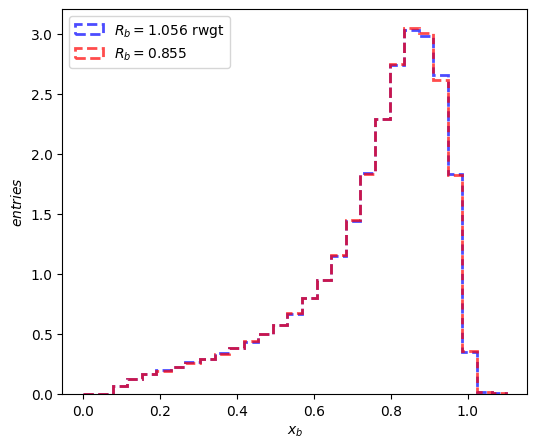

In [19]:
# xb
plt.figure(figsize=(6,5))
bins = np.linspace(0,1.1,30)
plot_style_0 = {'histtype':'step', 'color':'blue', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'histtype':'step', 'color':'red', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_2 = {'histtype':'step', 'color':'green', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_3 = {'histtype':'step', 'color':'orange', 'linewidth':2, 'linestyle':'--', 'density':True}
hist0 = plt.hist(X0_tot[:,0,0], bins = bins, alpha=0.7, weights=weights, label = r'$R_b = 1.056$ rwgt', **plot_style_0)
hist1 = plt.hist(X1_tot[:,0,0], bins = bins, alpha=0.7, label = r'$R_b = 0.855$', **plot_style_1)

plt.xlabel(r'$x_b$')
plt.ylabel('$entries$')
#plt.yscale('log')
plt.legend(loc='upper left')
plt.show()



NameError: name 'label_1' is not defined

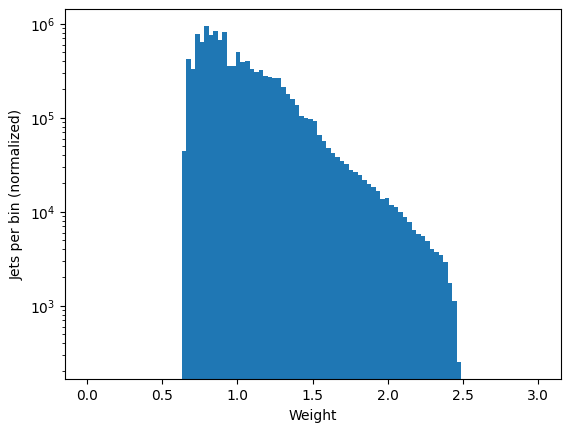

In [20]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights, 0, clip_val), bins = bins)
plt.yscale('log')
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_1 + r' $\rightarrow$ ' + label_0, fontsize=20)
plt.yscale('log')
plt.show()



In [32]:
!jupyter nbconvert Rb_bootstrapping_training.ipynb --to python


[NbConvertApp] Converting notebook Rb_bootstrapping_training.ipynb to python
[NbConvertApp] Writing 9758 bytes to Rb_bootstrapping_training.py
